# Emotional Classification Pipeline

In [ ]:
!pip install -U datasets

In [ ]:
!pip install sentence-transformers

## Install Packages

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset, concatenate_datasets, Dataset
from peft import LoraConfig, get_peft_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, hamming_loss
from sklearn.model_selection import train_test_split
import torch
import random
from transformers import pipeline, AutoModelForMaskedLM
import random
import re
import math
from sentence_transformers import SentenceTransformer, util

In [ ]:
def set_all_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # set_seed(seed)  # HuggingFace transformers seed


## Define Pipeline Parameters

In [ ]:
model_name = "Davlan/afro-xlmr-small"  # Base model name
run_baseline = False # Set to True to run the baseline model (skip data augmentation)
languages = ["afr", "hau", "swa"] # List of languages to include, can be run on all languages/specific ones
seed = 42 # Set a seed for reproducibility

emotion_labels = {
    "joy": 0,
    "anger": 1,
    "fear": 2,
    "sadness": 3,
    "disgust": 4,
    "surprise": 5,
    "neutral": 6,
}

set_all_seeds(seed)

## Load Datasets

In [ ]:
def load_datasets(languages):

    datasets = {}
    for lang in languages:
        print(f"Loading dataset for {lang}...")
        hf_dataset = load_dataset("brighter-dataset/BRIGHTER-emotion-categories", lang)

        combined_hf_dataset = concatenate_datasets([
            hf_dataset["train"],
            hf_dataset["test"],
            hf_dataset["dev"]
        ])
        datasets[lang] = combined_hf_dataset
        print(f"Loaded {len(combined_hf_dataset)} samples for {lang}.")


    return datasets


datasets = load_datasets(languages)

Loading dataset for afr...
Loaded 3548 samples for afr.
Loading dataset for hau...
Loaded 5017 samples for hau.
Loading dataset for swa...
Loaded 7721 samples for swa.


## Preprocess Dataset
- Map empty emotions to neutral
- Split in to train, validation and test sets using stratified sampling by emotion label
- Add multi-hot encoded label column

In [ ]:
def preprocess_datasets(datasets, emotion_to_id_dict):
    preprocessed_datasets = {}
    for lang, dataset in datasets.items():
        print(f"Preprocessing dataset for {lang}...")

        # Replace empty labels with "neutral"
        dataset = dataset.map(
            lambda example: {
                **example,
                "emotions": example["emotions"] if len(example["emotions"]) > 0 else ["neutral"]
            }
        )

        # Convert the list of emotions to a string representation for stratification
        def categorise_emotions(emotions_list):
            if not emotions_list:
                return "none"
            elif len(emotions_list) == 1:
                return emotions_list[0]
            else:
                return "multiple"

        # Add a new column for stratification
        dataset = dataset.map(
            lambda example: {"emotion_key": categorise_emotions(example["emotions"])}
        )

        # Now split using train_test_split from scikit-learn
        train_size = 0.8
        test_size = 0.1
        dev_size = 0.1

        # Convert to pandas for easier handling with sklearn
        df = dataset.to_pandas()

        print(f"Stratifying by emotion...")
        # First split to get train and the rest
        train_df, temp_df = train_test_split(
            df,
            train_size=train_size,
            stratify=df["emotion_key"],
            random_state=seed
        )

        # Then split the rest into test and dev
        test_df, dev_df = train_test_split(
            temp_df,
            train_size=test_size/(test_size + dev_size),
            stratify=temp_df["emotion_key"],
            random_state=seed
        )

        train_dataset = Dataset.from_pandas(train_df)
        test_dataset = Dataset.from_pandas(test_df)
        dev_dataset = Dataset.from_pandas(dev_df)


        num_labels = len(emotion_to_id_dict)

        # Create a new column 'labels' containing multi-hot encoded labels
        def map_emotions_to_labels(example):
            # Initialise a zero array for all emotions
            labels = [0.0] * num_labels  # Use floats instead of integers

            # Handle both string format and list format
            emotions_list = example['emotions']

            # Set 1 for each emotion present in the example
            for emotion in emotions_list:
                labels[emotion_to_id_dict[emotion]] = 1.0

            example['labels'] = labels
            return example

        # Apply the mapping function to the train, test, and dev datasets
        train_dataset = train_dataset.map(map_emotions_to_labels)
        test_dataset = test_dataset.map(map_emotions_to_labels)
        dev_dataset = dev_dataset.map(map_emotions_to_labels)


        print(f"Dataset for {lang} split with {len(train_dataset)} train, {len(test_dataset)} test, and {len(dev_dataset)} validation samples.")

        # Store the datasets in the dictionary
        preprocessed_datasets[lang] = {
            "train": train_dataset,
            "test": test_dataset,
            "validation": dev_dataset
        }
    return preprocessed_datasets


preprocessed_datasets = preprocess_datasets(datasets.copy(), emotion_labels)

Preprocessing dataset for afr...
Stratifying by emotion...


Map:   0%|          | 0/2838 [00:00<?, ? examples/s]

Map:   0%|          | 0/355 [00:00<?, ? examples/s]

Map:   0%|          | 0/355 [00:00<?, ? examples/s]

Dataset for afr split with 2838 train, 355 test, and 355 validation samples.
Preprocessing dataset for hau...
Stratifying by emotion...


Map:   0%|          | 0/4013 [00:00<?, ? examples/s]

Map:   0%|          | 0/502 [00:00<?, ? examples/s]

Map:   0%|          | 0/502 [00:00<?, ? examples/s]

Dataset for hau split with 4013 train, 502 test, and 502 validation samples.
Preprocessing dataset for swa...
Stratifying by emotion...


Map:   0%|          | 0/6176 [00:00<?, ? examples/s]

Map:   0%|          | 0/772 [00:00<?, ? examples/s]

Map:   0%|          | 0/773 [00:00<?, ? examples/s]

Dataset for swa split with 6176 train, 772 test, and 773 validation samples.


In [ ]:
from collections import defaultdict
import numpy as np

def count_label_distribution(preprocessed_datasets, emotion_labels):
    label_counts_per_lang = {}

    for lang, splits in preprocessed_datasets.items():
        print(f"\nLabel distribution for language: {lang}")
        label_counts = defaultdict(lambda: np.zeros(len(emotion_labels)))

        for split_name, dataset in splits.items():
            for example in dataset:
                label_counts[split_name] += np.array(example['labels'])

        id_to_emotion = {v: k for k, v in emotion_labels.items()}

        for split_name, counts in label_counts.items():
            print(f"\n{split_name.capitalize()} set:")
            for i, count in enumerate(counts):
                print(f"{id_to_emotion[i]}: {int(count)}")

        label_counts_per_lang[lang] = label_counts

    return label_counts_per_lang

# Call the function
label_distribution = count_label_distribution(preprocessed_datasets.copy(), emotion_labels)


Label distribution for language: afr

Train set:
joy: 1112
anger: 177
fear: 301
sadness: 439
disgust: 133
surprise: 0
neutral: 1075

Test set:
joy: 138
anger: 19
fear: 42
sadness: 58
disgust: 15
surprise: 0
neutral: 135

Validation set:
joy: 135
anger: 24
fear: 40
sadness: 56
disgust: 16
surprise: 0
neutral: 134

Label distribution for language: hau

Train set:
joy: 597
anger: 773
fear: 608
sadness: 1223
disgust: 623
surprise: 652
neutral: 517

Test set:
joy: 78
anger: 94
fear: 74
sadness: 151
disgust: 79
surprise: 85
neutral: 64

Validation set:
joy: 75
anger: 93
fear: 89
sadness: 147
disgust: 73
surprise: 80
neutral: 65

Label distribution for language: swa

Train set:
joy: 830
anger: 586
fear: 171
sadness: 647
disgust: 450
surprise: 1000
neutral: 2749

Test set:
joy: 104
anger: 72
fear: 24
sadness: 85
disgust: 54
surprise: 122
neutral: 343

Validation set:
joy: 103
anger: 71
fear: 22
sadness: 82
disgust: 54
surprise: 130
neutral: 344


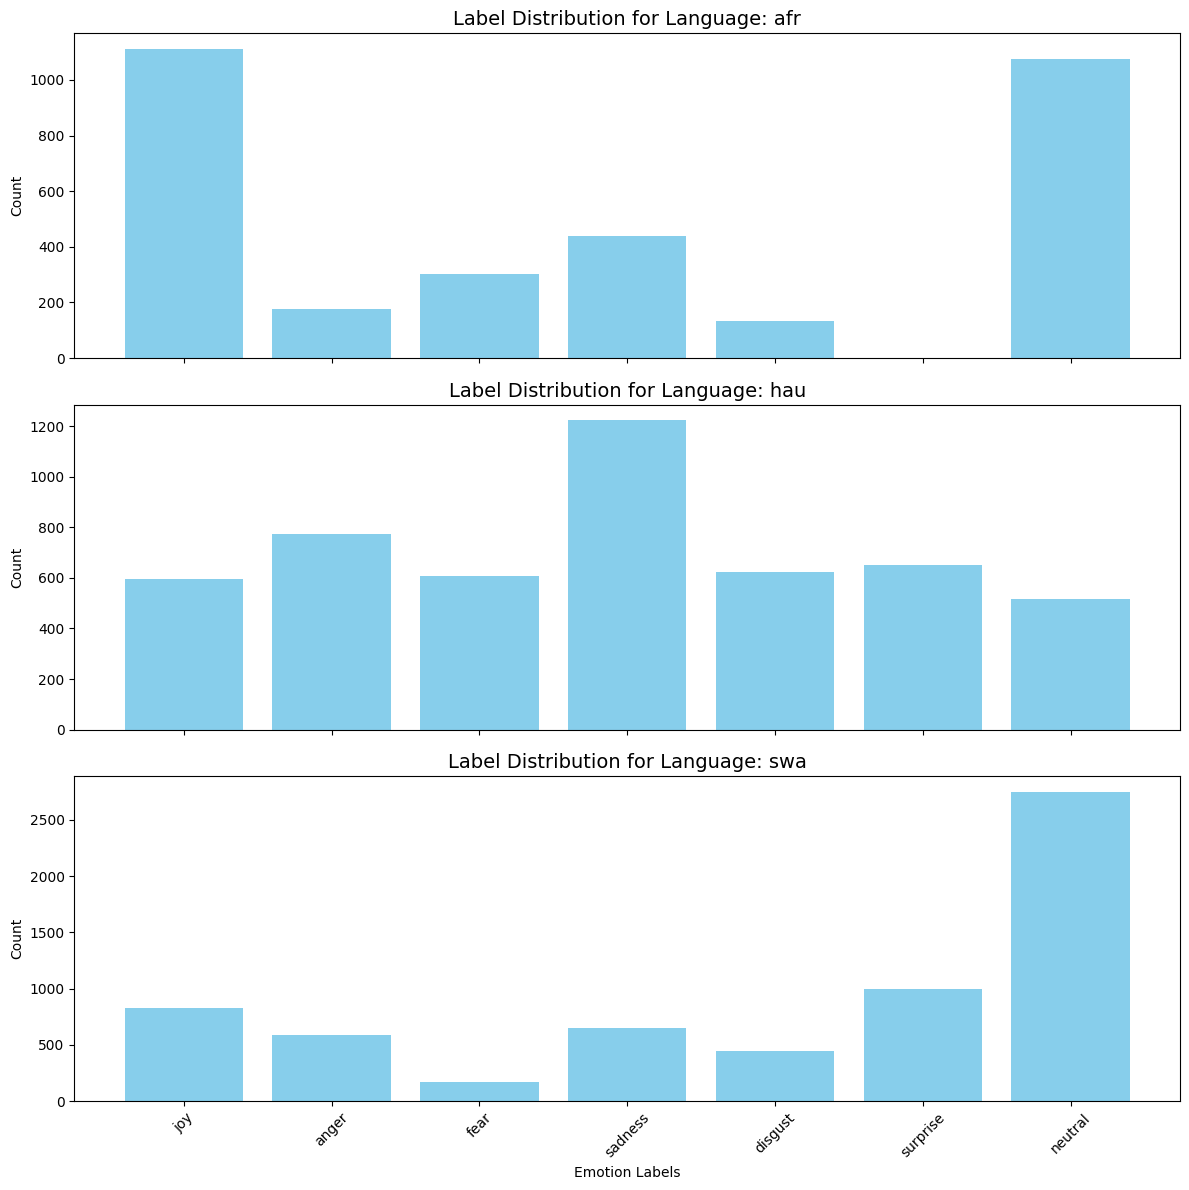

In [ ]:
import matplotlib.pyplot as plt

def draw_label_distribution(label_distribution, emotion_labels):
    label_names = [None] * len(emotion_labels)
    for name, idx in emotion_labels.items():
        label_names[idx] = name

    num_langs = len(label_distribution)
    fig, axes = plt.subplots(num_langs, 1, figsize=(12, 4 * num_langs), sharex=True)

    if num_langs == 1:
        axes = [axes]

    for i, (lang, split_counts_dict) in enumerate(label_distribution.items()):
        train_counts = split_counts_dict.get("train", np.zeros(len(label_names)))

        axes[i].bar(label_names, train_counts, color='skyblue')
        axes[i].set_title(f"Label Distribution for Language: {lang}", fontsize=14)
        axes[i].set_ylabel("Count")
        axes[i].set_xticks(range(len(label_names)))
        axes[i].set_xticklabels(label_names, rotation=45)

    plt.xlabel("Emotion Labels")
    plt.tight_layout()
    plt.show()

draw_label_distribution(label_distribution, emotion_labels)

# Apply data augmentation techique
> Skips if running baseline model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name)

fill_mask = pipeline("fill-mask", model=model, tokenizer=tokenizer, top_k=5)

Device set to use cuda:0


In [ ]:
modelSentenceTransformer = SentenceTransformer('sentence-transformers/LaBSE')

def is_semantically_similar(sent1, sent2, model, threshold=0.75):
    embeddings = model.encode([sent1, sent2], convert_to_tensor=True)
    sim = util.pytorch_cos_sim(embeddings[0], embeddings[1]).item()
    return sim >= threshold


In [ ]:
# Mignon added
def mlm_augment_text(text, num_masks=None, max_tries=5, language="swa", model=None, threshold=0.75):
    """
    Augment text using MLM, masking 15% of words without skipping emotion/stop words.
    """
    # Tokenize
    tokens = re.findall(r'\w+|[^\w\s]', text, re.UNICODE)
    if len(tokens) < 3:
        return None

    # Mask only alphabetical tokens (no punctuation)
    valid_indices = [i for i, tok in enumerate(tokens) if tok.isalpha()]
    if not valid_indices:
        return None

    # Determine number of tokens to mask (15% of valid tokens, min 1)
    if num_masks is None:
        num_masks = max(1, math.ceil(0.15 * len(valid_indices)))
        print(f"masked 15%, num_masks={num_masks}, valid_indices={len(valid_indices)}")

    for _ in range(max_tries):
        mask_indices = random.sample(valid_indices, min(num_masks, len(valid_indices)))
        masked_tokens = tokens.copy()

        for idx in mask_indices:
            masked_tokens[idx] = tokenizer.mask_token

        # Fill in each mask
        for idx in sorted(mask_indices):
            masked_sentence = " ".join(masked_tokens)
            print("Masked Sentence:", masked_sentence)

            try:
                predictions = fill_mask(masked_sentence)
                if predictions:
                    best_prediction = random.choice(predictions[:3])['token_str'].strip()
                    masked_tokens[idx] = best_prediction
            except Exception:
                continue

        augmented_sentence = " ".join(masked_tokens)

        if augmented_sentence != text and model is not None:
            if is_semantically_similar(text, augmented_sentence, modelSentenceTransformer, threshold):
                return augmented_sentence
        elif augmented_sentence != text:
            return augmented_sentence

    return "NO_AUGMENTATION"

In [ ]:
def get_label_counts(dataset):
  # Count each individual emotion
  emotion_counter = Counter()
  df = dataset.to_pandas()

  # Iterate through each row in the DataFrame
  for emotions_list in df['emotions']:
      # Add each emotion to the counter
      for emotion in emotions_list:
          emotion_counter[emotion] += 1

  # Display results
  return emotion_counter

In [ ]:
def get_label_aug_percentages(train_dataset, lang):

  aug_per_label = []

  print(f"Total number of training instances before augmentation: {len(train_dataset)}")
  print(f"Training distribution before augmentation:")
  label_counts = get_label_counts(train_dataset)
  number_of_labels = len(label_counts)
  ideal_distribution = 1 / number_of_labels

  for emotion, count in label_counts.items():
    percentage = count/len(train_dataset)
    print(f"{emotion}: {count} - {round(percentage*100)}%")
    if percentage >= 1.5 * ideal_distribution:
      print(f"Label {emotion} is over represented")
      aug_per_label.append({"label": emotion, "to_augment": 1.0})
    if percentage >= ideal_distribution:
      print(f"Label {emotion} is well represented")
      aug_per_label.append({"label": emotion, "to_augment": 1.3})
    elif (ideal_distribution - percentage) <= 0.05:
      print(f"Label {emotion} is moderately represented")
      aug_per_label.append({"label": emotion, "to_augment": 2.0})
    elif (ideal_distribution - percentage) <= 0.10:
      print(f"Label {emotion} is underrepresented")
      aug_per_label.append({"label": emotion, "to_augment": 3.0})
    else:
      print(f"Label {emotion} is extremely underrepresented")
      aug_per_label.append({"label": emotion, "to_augment": 3.0})

  return aug_per_label, label_counts



In [ ]:
from collections import Counter

In [ ]:
def augment_datasets(datasets):
  if run_baseline:
      print("Running baseline model, skipping data augmentation.")
      return datasets

  augmented_datasets = {}

  for lang, dataset in datasets.items():
      print(f"\n-------------- Applying data augmentation for {lang} --------------")
      training_set = dataset["train"]
      validation_set = dataset["validation"]
      test_set = dataset["test"]

      augmentation_per_label, label_counts = get_label_aug_percentages(training_set, lang)

      augmented_training_list = training_set.to_list()

      for apl in augmentation_per_label:
          label = apl["label"]
          aug_amount = apl["to_augment"]
          target_count = label_counts[label] * aug_amount
          current_count = label_counts[label]

          print(f"Augmenting label: '{label}'...")
          if current_count >= target_count:
              print(f"Label '{label}' already has {current_count} samples, no augmentation needed.")
              continue

          num_to_generate = int(target_count - current_count)
          augmentations_per_instance = min(math.ceil(num_to_generate/current_count), 4)
          print(f"Generating approx. {num_to_generate} samples for '{label}'...")

          original_samples_for_label = []
          for sample in training_set:
              if label in sample['emotions']:
                  original_samples_for_label.append(sample)

          if not original_samples_for_label:
              print(f"Warning: No samples found with label '{label}' for augmentation.")
              continue

          augmented_samples = []
          num_augmented = 0

          for instance in original_samples_for_label:
            if num_augmented >= num_to_generate:
              break
            original_text = instance["text"]
            augmented_text = mlm_augment_text(original_text, num_masks=None, language=lang, model=model, threshold=0.75)
            if augmented_text and augmented_text != original_text:
                new_sample = instance.copy()
                new_sample["text"] = augmented_text
                augmented_samples.append(new_sample)
                num_augmented += 1

          augmented_training_list.extend(augmented_samples)

      for i, item in enumerate(augmented_training_list):
        if not isinstance(item, dict):
            print(f"Item {i} is not a dict:", item)

      augmented_train_dataset = Dataset.from_list(augmented_training_list)

      print(f"Total number of training instances after augmentation: {len(augmented_training_list)}")
      print(f"\nTraining distribution after augmentation for {lang}")
      augmented_label_counts = get_label_counts(augmented_train_dataset)
      for emotion, count in augmented_label_counts.items():
        percentage = count/len(augmented_train_dataset)
        print(f"{emotion}: {count} - {round(percentage*100)}")

      augmented_datasets[lang] = {
          "train": augmented_train_dataset,
          "test": test_set,
          "validation": validation_set
      }

  return augmented_datasets


augmented_datasets = augment_datasets(preprocessed_datasets.copy())


-------------- Applying data augmentation for afr --------------
Total number of training instances before augmentation: 2838
Training distribution before augmentation:
fear: 301 - 11%
Label fear is underrepresented
anger: 177 - 6%
Label anger is extremely underrepresented
disgust: 133 - 5%
Label disgust is extremely underrepresented
neutral: 1075 - 38%
Label neutral is over represented
Label neutral is well represented
joy: 1112 - 39%
Label joy is over represented
Label joy is well represented
sadness: 439 - 15%
Label sadness is moderately represented
Augmenting label: 'fear'...
Generating approx. 602 samples for 'fear'...
masked 15%, num_masks=3, valid_indices=20
Masked Sentence: <mask> is vinnige <mask> wanneer daar tekens van ' <mask> moontlike uitbraak van een of ander siekte is , van kardinale belang .
Masked Sentence: <mask> is vinnige <mask> wanneer daar tekens van ' <mask> moontlike uitbraak van een of ander siekte is , van kardinale belang .
Masked Sentence: <mask> is vinnig

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Streaming output truncated to the last 5000 lines.
Masked Sentence: <mask> btw ni sawa mtupee gigs ama <mask>
Masked Sentence: <mask> <mask> ni sawa mtupee gigs ama muache
Masked Sentence: <mask> <mask> ni sawa mtupee gigs ama muache
Masked Sentence: nmelewa btw ni sawa mtupee gigs <mask> <mask>
Masked Sentence: nmelewa btw ni sawa mtupee gigs <mask> <mask>
Masked Sentence: nmelewa <mask> <mask> sawa mtupee gigs ama muache
Masked Sentence: nmelewa <mask> <mask> sawa mtupee gigs ama muache
Masked Sentence: nmelewa btw <mask> sawa <mask> gigs ama muache
Masked Sentence: nmelewa btw <mask> sawa <mask> gigs ama muache
masked 15%, num_masks=2, valid_indices=9
Masked Sentence: mwenye aliuza giroud kwenda chelsea <mask> viboko <mask> sana
Masked Sentence: mwenye aliuza giroud kwenda chelsea <mask> viboko <mask> sana
masked 15%, num_masks=2, valid_indices=9
Masked Sentence: <mask> <mask> mrembo , lakin kitu anatuwekea dp ni meme 😪 🤢
Masked Sentence: <mask> <mask> mrembo , lakin kitu anatuwekea

In [ ]:
label_distribution = count_label_distribution(augmented_datasets.copy(), emotion_labels)


Label distribution for language: afr

Train set:
joy: 1486
anger: 560
fear: 799
sadness: 1178
disgust: 460
surprise: 0
neutral: 1397

Test set:
joy: 138
anger: 19
fear: 42
sadness: 58
disgust: 15
surprise: 0
neutral: 135

Validation set:
joy: 135
anger: 24
fear: 40
sadness: 56
disgust: 16
surprise: 0
neutral: 134

Label distribution for language: hau

Train set:
joy: 805
anger: 1123
fear: 922
sadness: 1828
disgust: 888
surprise: 923
neutral: 1034

Test set:
joy: 78
anger: 94
fear: 74
sadness: 151
disgust: 79
surprise: 85
neutral: 64

Validation set:
joy: 75
anger: 93
fear: 89
sadness: 147
disgust: 73
surprise: 80
neutral: 65

Label distribution for language: swa

Train set:
joy: 1704
anger: 1243
fear: 368
sadness: 1372
disgust: 985
surprise: 1419
neutral: 3573

Test set:
joy: 104
anger: 72
fear: 24
sadness: 85
disgust: 54
surprise: 122
neutral: 343

Validation set:
joy: 103
anger: 71
fear: 22
sadness: 82
disgust: 54
surprise: 130
neutral: 344


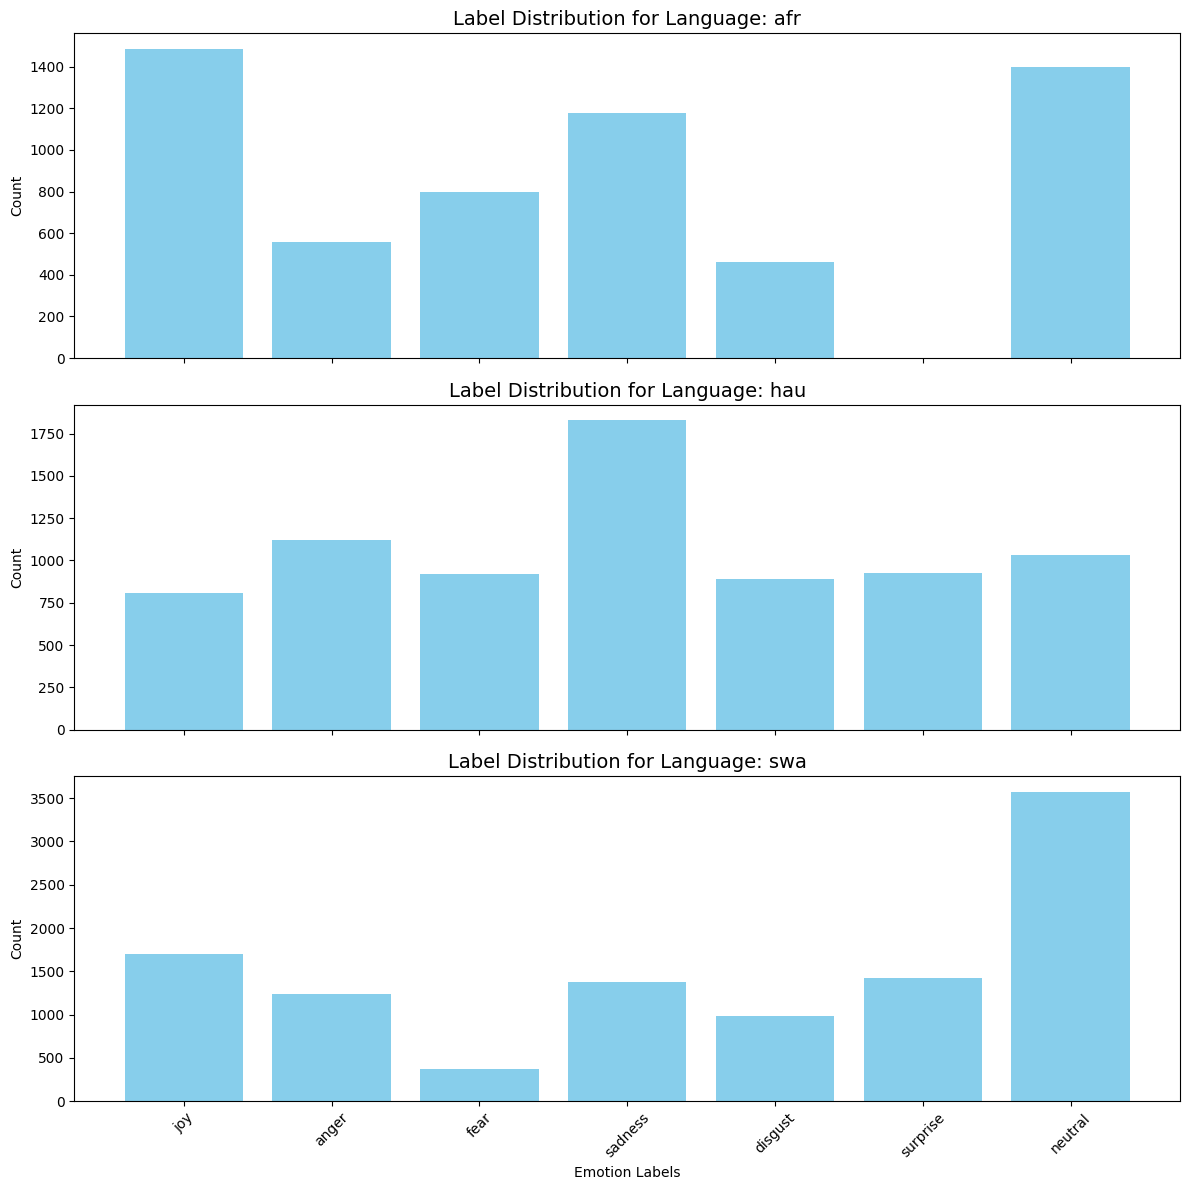

In [ ]:
draw_label_distribution(label_distribution, emotion_labels)

# Tokenize the datasets

In [ ]:
xmlr_tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess(batch):
    return xmlr_tokenizer(batch['text'], truncation=True, padding='max_length', max_length=128)

tokenized_datasets = {}
for lang, dataset in augmented_datasets.items():
    print(f"Tokenizing dataset for {lang}...")
    tokenized_datasets[lang] = {}
    tokenized_datasets[lang]['train'] = dataset['train'].map(preprocess, batched=True)
    tokenized_datasets[lang]['test'] = dataset['test'].map(preprocess, batched=True)
    tokenized_datasets[lang]['validation'] = dataset['validation'].map(preprocess, batched=True)
    tokenized_datasets[lang]['train'].set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    tokenized_datasets[lang]['test'].set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    tokenized_datasets[lang]['validation'].set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    print(f"Tokenized dataset for {lang}")



Tokenizing dataset for afr...


Map:   0%|          | 0/4543 [00:00<?, ? examples/s]

Map:   0%|          | 0/355 [00:00<?, ? examples/s]

Map:   0%|          | 0/355 [00:00<?, ? examples/s]

Tokenized dataset for afr
Tokenizing dataset for hau...


Map:   0%|          | 0/5869 [00:00<?, ? examples/s]

Map:   0%|          | 0/502 [00:00<?, ? examples/s]

Map:   0%|          | 0/502 [00:00<?, ? examples/s]

Tokenized dataset for hau
Tokenizing dataset for swa...


Map:   0%|          | 0/9978 [00:00<?, ? examples/s]

Map:   0%|          | 0/772 [00:00<?, ? examples/s]

Map:   0%|          | 0/773 [00:00<?, ? examples/s]

Tokenized dataset for swa


# Train Model

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    hamming_loss,
    multilabel_confusion_matrix
)
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    sigmoid = lambda x: 1 / (1 + np.exp(-x))
    probs = sigmoid(logits)
    preds = (probs >= 0.3).astype(int)

    mcm = multilabel_confusion_matrix(labels, preds)

    confusion_dict = {
        f"label_{i}": {
            "tn": int(cm[0][0]),
            "fp": int(cm[0][1]),
            "fn": int(cm[1][0]),
            "tp": int(cm[1][1]),
        }
        for i, cm in enumerate(mcm)
    }

    # Use macro and micro averages for evaluation
    return {
        "subset_accuracy": accuracy_score(labels, preds),
        "hamming_loss": hamming_loss(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro", zero_division=0),
        "micro_f1": f1_score(labels, preds, average="micro", zero_division=0),
        "macro_precision": precision_score(labels, preds, average="macro", zero_division=0),
        "micro_precision": precision_score(labels, preds, average="micro", zero_division=0),
        "macro_recall": recall_score(labels, preds, average="macro", zero_division=0),
        "micro_recall": recall_score(labels, preds, average="micro", zero_division=0),
        "confusion_matrix": confusion_dict
    }

def train_finetune(train_data, val_data, num_labels, lang):
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
        problem_type="multi_label_classification"  # Set problem type for multi-label
    )

    args = TrainingArguments(
        output_dir=f"{model_name}-{lang}-ft",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=5,
        save_strategy="no",
        report_to="none",
        logging_dir=None,
        seed=seed,  # Add seed to training arguments
        data_seed=seed,  # Add data seed for data loading
        dataloader_num_workers=0,  # Ensure deterministic data loading
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_data,
        eval_dataset=val_data,
        compute_metrics=compute_metrics
    )
    trainer.train()
    return trainer


trainers = {}
for lang, datasets in augmented_datasets.items():
    print(f"\nTraining on {lang} dataset...")

    num_labels = len(emotion_labels)
    set_all_seeds(seed)
    trainers[lang] = train_finetune(tokenized_datasets[lang]["train"],tokenized_datasets[lang]["validation"], num_labels, lang)
    results = trainers[lang].evaluate(tokenized_datasets[lang]["validation"], metric_key_prefix="eval")
    print("Training Fine-tuning Accuracy:", results['eval_subset_accuracy'])
    print("Training Hamming Loss:", results['eval_hamming_loss'])
    print("Macro F1 Score", results['eval_macro_f1'])
    print("Micro F1 Score", results['eval_micro_f1'])
    print("Micro Precision", results['eval_micro_precision'])
    print("Micro Recall", results['eval_micro_recall'])
    print("Macro Precision", results['eval_macro_precision'])
    print("Macro Recall", results['eval_macro_recall'])
    print("Confusion Matrix", results['eval_confusion_matrix'])


Training on afr dataset...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.268300
1000,0.096300


Training Fine-tuning Accuracy: 0.7774647887323943
Training Hamming Loss: 0.05714285714285714
Macro F1 Score 0.6820565546121546
Micro F1 Score 0.8272506082725061
Micro Precision 0.815347721822542
Micro Recall 0.8395061728395061
Macro Precision 0.6854986984001125
Macro Recall 0.6815282995453572
Confusion Matrix {'label_0': {'tn': 197, 'fp': 23, 'fn': 17, 'tp': 118}, 'label_1': {'tn': 327, 'fp': 4, 'fn': 8, 'tp': 16}, 'label_2': {'tn': 306, 'fp': 9, 'fn': 9, 'tp': 31}, 'label_3': {'tn': 283, 'fp': 16, 'fn': 9, 'tp': 47}, 'label_4': {'tn': 336, 'fp': 3, 'fn': 4, 'tp': 12}, 'label_5': {'tn': 355, 'fp': 0, 'fn': 0, 'tp': 0}, 'label_6': {'tn': 199, 'fp': 22, 'fn': 18, 'tp': 116}}

Training on hau dataset...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.375600
1000,0.245300
1500,0.169900


Training Fine-tuning Accuracy: 0.6075697211155379
Training Hamming Loss: 0.09391007398975526
Macro F1 Score 0.7434562297043621
Micro F1 Score 0.7496206373292867
Micro Precision 0.7097701149425287
Micro Recall 0.7942122186495176
Macro Precision 0.7187700450112795
Macro Recall 0.7785086241225995
Confusion Matrix {'label_0': {'tn': 405, 'fp': 22, 'fn': 8, 'tp': 67}, 'label_1': {'tn': 380, 'fp': 29, 'fn': 21, 'tp': 72}, 'label_2': {'tn': 388, 'fp': 25, 'fn': 9, 'tp': 80}, 'label_3': {'tn': 288, 'fp': 67, 'fn': 21, 'tp': 126}, 'label_4': {'tn': 421, 'fp': 8, 'fn': 16, 'tp': 57}, 'label_5': {'tn': 392, 'fp': 30, 'fn': 21, 'tp': 59}, 'label_6': {'tn': 416, 'fp': 21, 'fn': 32, 'tp': 33}}

Training on swa dataset...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.378900
1000,0.372800
1500,0.313300
2000,0.266400
2500,0.215100
3000,0.168300


Training Fine-tuning Accuracy: 0.5329883570504528
Training Hamming Loss: 0.12012566993162077
Macro F1 Score 0.48779127977828424
Micro F1 Score 0.622093023255814
Micro Precision 0.5853391684901532
Micro Recall 0.6637717121588089
Macro Precision 0.4477288151794676
Macro Recall 0.5399249652349983
Confusion Matrix {'label_0': {'tn': 612, 'fp': 58, 'fn': 39, 'tp': 64}, 'label_1': {'tn': 649, 'fp': 53, 'fn': 26, 'tp': 45}, 'label_2': {'tn': 750, 'fp': 1, 'fn': 22, 'tp': 0}, 'label_3': {'tn': 639, 'fp': 52, 'fn': 34, 'tp': 48}, 'label_4': {'tn': 684, 'fp': 35, 'fn': 29, 'tp': 25}, 'label_5': {'tn': 554, 'fp': 89, 'fn': 36, 'tp': 94}, 'label_6': {'tn': 338, 'fp': 91, 'fn': 85, 'tp': 259}}


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def plot_multilabel_roc(trainer, dataset, emotion_labels, lang):
    # Get raw predictions and labels
    outputs = trainer.predict(dataset)
    logits = outputs.predictions
    labels = outputs.label_ids

    sigmoid = lambda x: 1 / (1 + np.exp(-x))
    probs = sigmoid(logits)

    num_labels = len(emotion_labels)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_labels):
        fpr[i], tpr[i], _ = roc_curve(labels[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    label_names = [None] * len(emotion_labels)
    for k, v in emotion_labels.items():
        label_names[v] = k

    # Plot
    plt.figure(figsize=(10, 8))
    for i in range(num_labels):
        plt.plot(fpr[i], tpr[i], label=f"{label_names[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves for Language: {lang}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Plotting ROC curve for afr


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


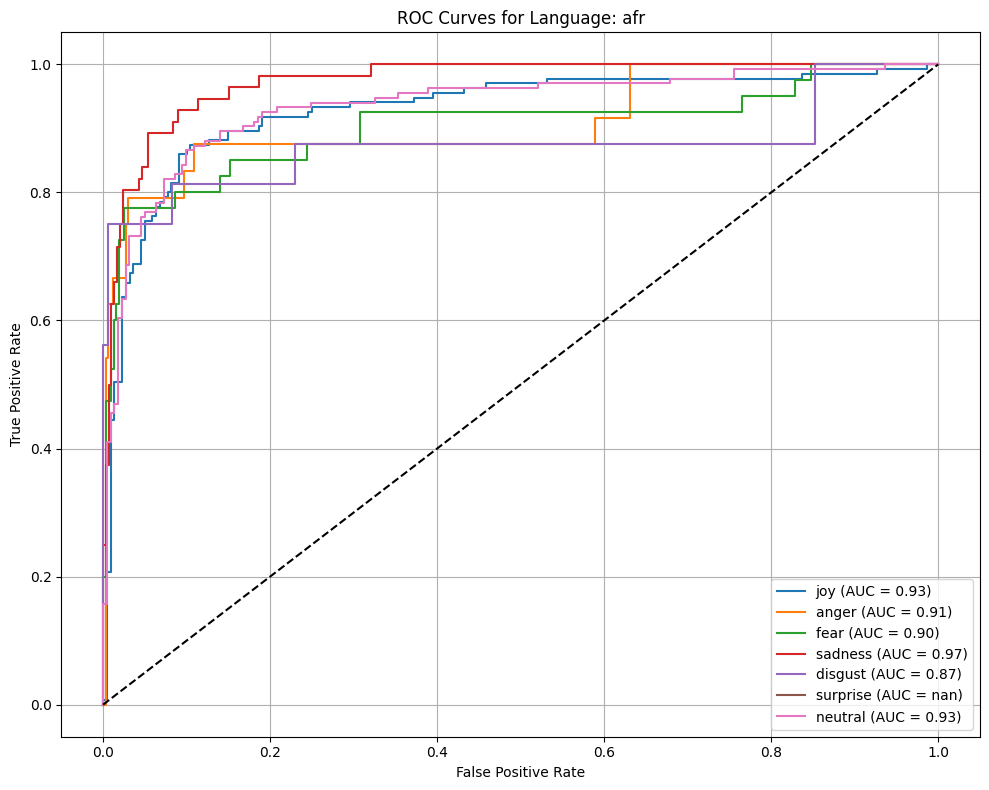

Plotting ROC curve for hau


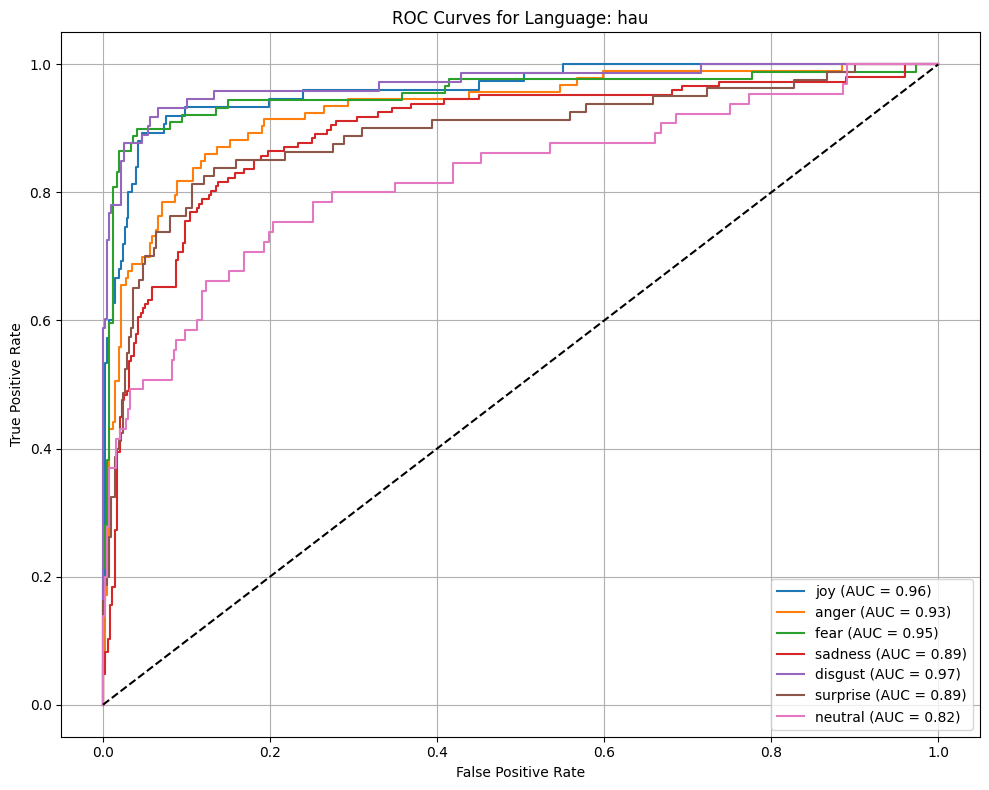

Plotting ROC curve for swa


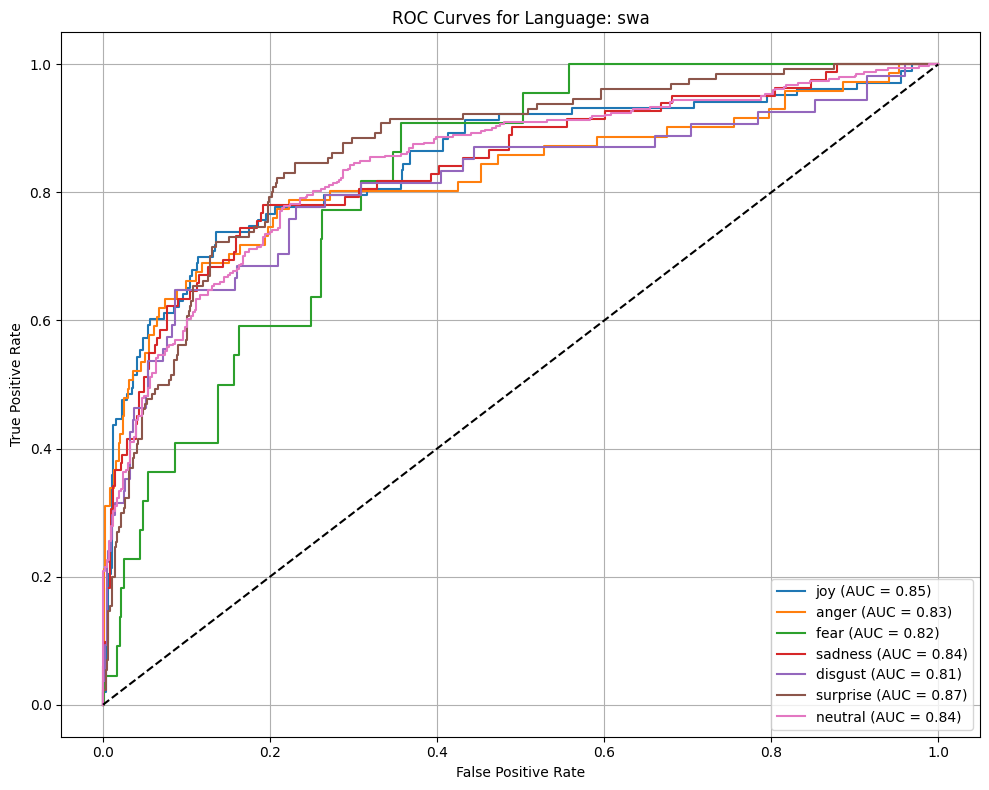

In [ ]:
for lang in trainers:
    print(f"Plotting ROC curve for {lang}")
    plot_multilabel_roc(trainers[lang], tokenized_datasets[lang]["validation"], emotion_labels, lang)

# Test Model

In [ ]:
def test_model(trainer, test_data):
    # Reuse the already loaded tokenizer
    test_results = trainer.evaluate(
        test_data,
        metric_key_prefix="test"
    )

    print("Test Accuracy:", test_results['test_subset_accuracy'])
    print("Test Hamming Loss:", test_results['test_hamming_loss'])
    print("Test Macro F1 Score:", test_results['test_macro_f1'])
    print("Test Micro F1 Score:", test_results['test_micro_f1'])
    print("Test Micro Precision:", test_results['test_micro_precision'])
    print("Test Micro Recall:", test_results['test_micro_recall'])
    print("Test Macro Precision:", test_results['test_macro_precision'])
    print("Test Macro Recall:", test_results['test_macro_recall'])
    print("Test Confusion Matrix:", test_results['test_confusion_matrix'])

    return test_results

for lang, datasets in augmented_datasets.items():
    print(f"\nTesting {lang} model on test {lang} dataset...")
    test_results = test_model(trainers[lang], tokenized_datasets[lang]["test"])



Testing afr model on test afr dataset...


Test Accuracy: 0.7408450704225352
Test Hamming Loss: 0.06720321931589537
Test Macro F1 Score: 0.6726138652910058
Test Micro F1 Score: 0.795593635250918
Test Micro Precision: 0.7926829268292683
Test Micro Recall: 0.7985257985257985
Test Macro Precision: 0.6818575736518209
Test Macro Recall: 0.6649420486081103
Test Confusion Matrix: {'label_0': {'tn': 191, 'fp': 26, 'fn': 23, 'tp': 115}, 'label_1': {'tn': 332, 'fp': 4, 'fn': 5, 'tp': 14}, 'label_2': {'tn': 297, 'fp': 16, 'fn': 14, 'tp': 28}, 'label_3': {'tn': 287, 'fp': 10, 'fn': 11, 'tp': 47}, 'label_4': {'tn': 339, 'fp': 1, 'fn': 3, 'tp': 12}, 'label_5': {'tn': 355, 'fp': 0, 'fn': 0, 'tp': 0}, 'label_6': {'tn': 192, 'fp': 28, 'fn': 26, 'tp': 109}}

Testing hau model on test hau dataset...


Test Accuracy: 0.6434262948207171
Test Hamming Loss: 0.08764940239043825
Test Macro F1 Score: 0.7567435292275165
Test Micro F1 Score: 0.7638036809815951
Test Micro Precision: 0.7334315169366715
Test Micro Recall: 0.7968
Test Macro Precision: 0.7426641839744387
Test Macro Recall: 0.7839247649823463
Test Confusion Matrix: {'label_0': {'tn': 395, 'fp': 29, 'fn': 14, 'tp': 64}, 'label_1': {'tn': 373, 'fp': 35, 'fn': 17, 'tp': 77}, 'label_2': {'tn': 401, 'fp': 27, 'fn': 8, 'tp': 66}, 'label_3': {'tn': 302, 'fp': 49, 'fn': 21, 'tp': 130}, 'label_4': {'tn': 415, 'fp': 8, 'fn': 27, 'tp': 52}, 'label_5': {'tn': 399, 'fp': 18, 'fn': 16, 'tp': 69}, 'label_6': {'tn': 423, 'fp': 15, 'fn': 24, 'tp': 40}}

Testing swa model on test swa dataset...


Test Accuracy: 0.594559585492228
Test Hamming Loss: 0.10399703923019986
Test Macro F1 Score: 0.5631272778595758
Test Micro F1 Score: 0.6713450292397661
Test Micro Precision: 0.6335540838852097
Test Micro Recall: 0.7139303482587065
Test Macro Precision: 0.6373276534883358
Test Macro Recall: 0.5932103113783279
Test Confusion Matrix: {'label_0': {'tn': 628, 'fp': 40, 'fn': 32, 'tp': 72}, 'label_1': {'tn': 660, 'fp': 40, 'fn': 25, 'tp': 47}, 'label_2': {'tn': 748, 'fp': 0, 'fn': 21, 'tp': 3}, 'label_3': {'tn': 637, 'fp': 50, 'fn': 38, 'tp': 47}, 'label_4': {'tn': 686, 'fp': 32, 'fn': 24, 'tp': 30}, 'label_5': {'tn': 583, 'fp': 67, 'fn': 31, 'tp': 91}, 'label_6': {'tn': 326, 'fp': 103, 'fn': 59, 'tp': 284}}


Plotting ROC curve for afr


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


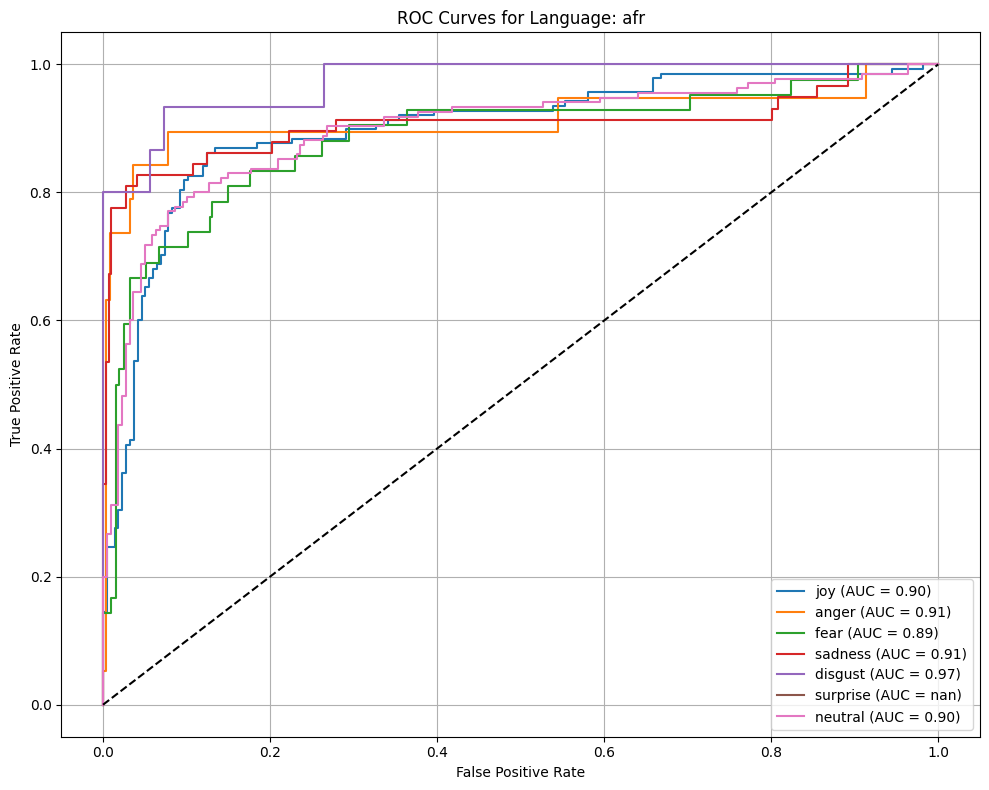

Plotting ROC curve for hau


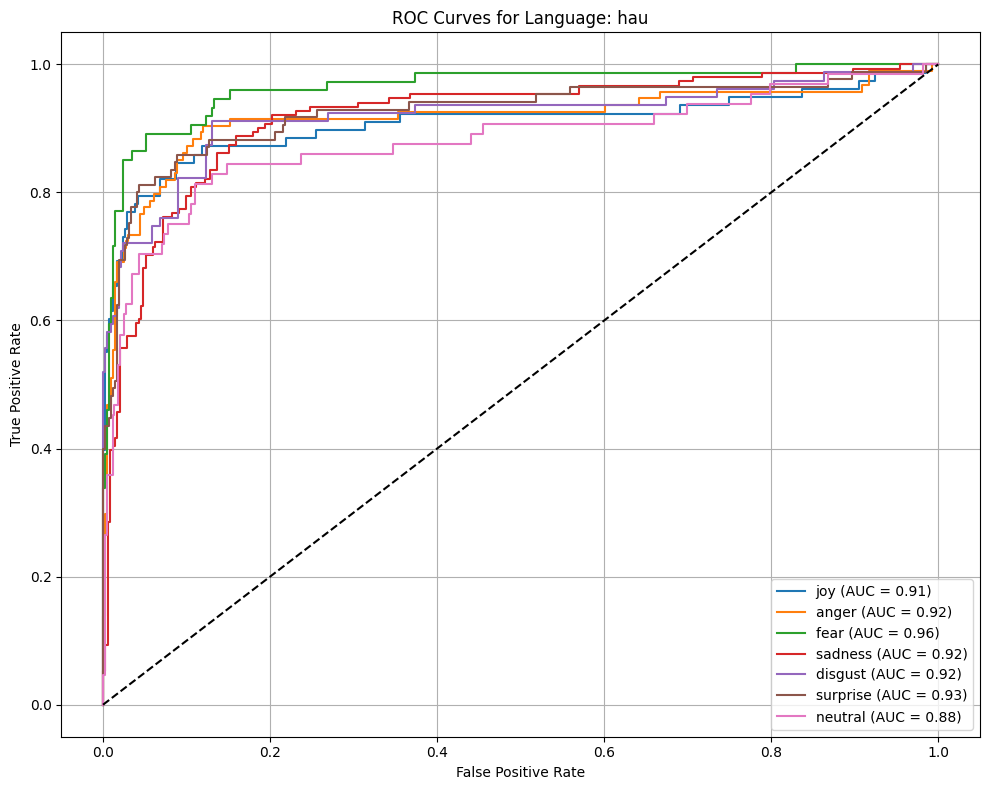

Plotting ROC curve for swa


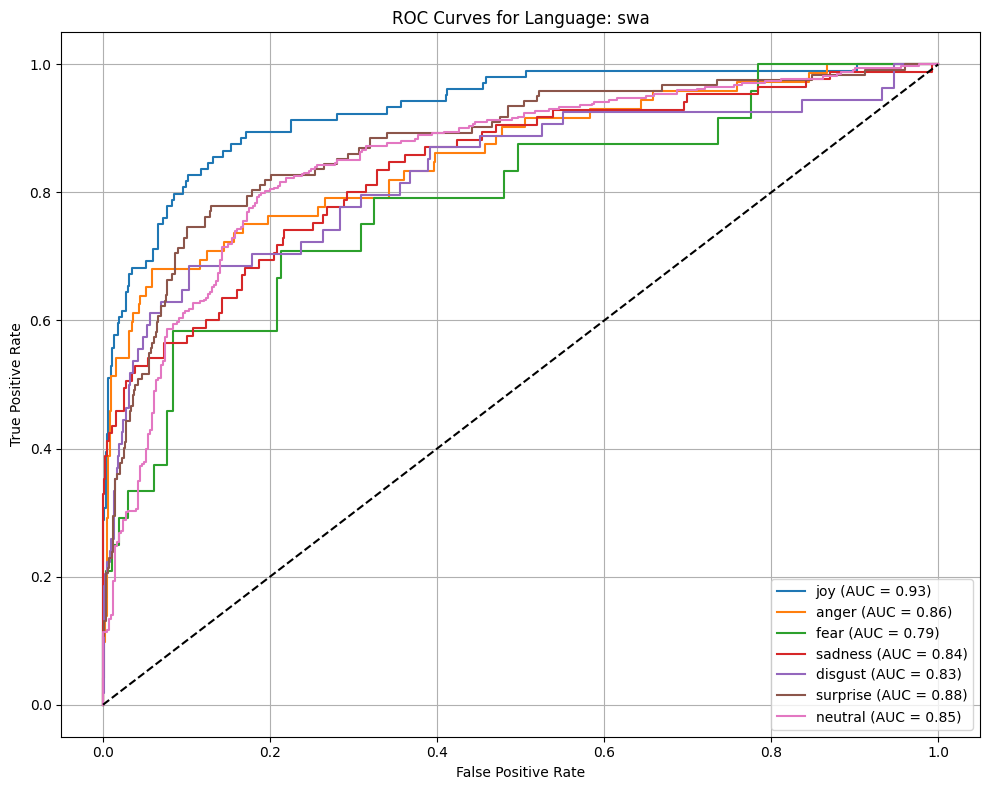

In [ ]:
for lang in trainers:
    print(f"Plotting ROC curve for {lang}")
    plot_multilabel_roc(trainers[lang], tokenized_datasets[lang]["test"], emotion_labels, lang)

# Parameter Tuning

In [ ]:
# param_grid = {
#     "learning_rate": [2e-5, 3e-5, 5e-5],
#     "batch_size": [8, 16],
#     "epochs": [3, 5],
#     "threshold": [0.3, 0.5, 0.7]
# }


In [ ]:
# def train_finetune(model_ckpt, train_data, test_data, num_labels, lr, batch_size, epochs, threshold):
#     model = AutoModelForSequenceClassification.from_pretrained(
#         model_ckpt,
#         num_labels=num_labels,
#         problem_type="multi_label_classification"
#     )


#     args = TrainingArguments(
#         output_dir=f"{model_ckpt}-finetuned",
#         per_device_train_batch_size=batch_size,
#         per_device_eval_batch_size=batch_size,
#         learning_rate=lr,
#         num_train_epochs=epochs,
#         save_strategy="no",
#         report_to="none",
#         logging_dir=None,
#         seed=seed,  # Add seed to training arguments
#         data_seed=seed,  # Add data seed for data loading
#         dataloader_num_workers=0,  # Ensure deterministic data loading
#     )

#     def compute_metrics(eval_pred):
#         logits, labels = eval_pred
#         sigmoid = lambda x: 1 / (1 + np.exp(-x))
#         probs = sigmoid(logits)
#         preds = (probs >= threshold).astype(int)

#         return {
#             "subset_accuracy": accuracy_score(labels, preds),
#             "hamming_loss": hamming_loss(labels, preds),
#             "macro_f1": f1_score(labels, preds, average="macro", zero_division=0),
#             "micro_f1": f1_score(labels, preds, average="micro", zero_division=0),
#         }

#     trainer = Trainer(
#         model=model,
#         args=args,
#         train_dataset=train_data,
#         eval_dataset=test_data,
#         compute_metrics=compute_metrics
#     )

#     trainer.train()
#     results = trainer.evaluate()
#     return results


In [ ]:
# import itertools
# import numpy as np
# from collections import defaultdict

# # Dictionary to store results for each language
# language_results = {}
# # Dictionary to track average performance across languages for each parameter combination
# param_avg_scores = defaultdict(float)
# # To count how many languages we test on (for averaging)
# num_languages = len(languages)

# # Create a compact parameter key format for readability
# def param_key(lr, batch_size, epochs, threshold):
#     return f"lr={lr}_bs={batch_size}_ep={epochs}_th={threshold}"

# print(f"Parameter tuning across {num_languages} languages: {', '.join(languages)}")

# num_labels = len(emotion_labels)
# # Generate all parameter combinations once
# param_combinations = list(itertools.product(
#     param_grid["learning_rate"],
#     param_grid["batch_size"],
#     param_grid["epochs"],
#     param_grid["threshold"]
# ))

# # First, train and evaluate on each language separately
# for lang in languages:
#     print(f"\n{'='*50}")
#     print(f"TUNING ON LANGUAGE: {lang}")
#     print(f"{'='*50}")

#     language_results[lang] = []
#     best_lang_score = 0
#     best_lang_params = {}

#     for lr, batch_size, epochs, threshold in param_combinations:
#         print(f"\nTesting on {lang}: lr={lr}, batch_size={batch_size}, epochs={epochs}, threshold={threshold}")

#         set_all_seeds(seed)
#         # Train and evaluate on this language with these parameters
#         results = train_finetune(
#             "Davlan/afro-xlmr-small",
#             tokenized_datasets[lang]["train"],
#             tokenized_datasets[lang]["validation"],
#             num_labels, lr, batch_size, epochs, threshold
#         )

#         # Extract the score (using micro_f1 as our metric)
#         score = results["eval_micro_f1"]
#         print(f"{lang} Micro-F1 Score: {score:.4f}")

#         # Store results for this language
#         language_results[lang].append((score, lr, batch_size, epochs, threshold))

#         # Update best parameters for this language
#         if score > best_lang_score:
#             best_lang_score = score
#             best_lang_params = {
#                 "learning_rate": lr,
#                 "batch_size": batch_size,
#                 "epochs": epochs,
#                 "threshold": threshold
#             }

#         # Add to our running average across languages
#         param_key_str = param_key(lr, batch_size, epochs, threshold)
#         param_avg_scores[param_key_str] += score / num_languages

#     # Print the best parameters for this language
#     print(f"\n✅ Best parameters for {lang}:")
#     print(best_lang_params)
#     print(f"Best {lang} Micro-F1 Score: {best_lang_score:.4f}")

# # Find the parameter combination with the best average performance across languages
# best_avg_score = 0
# best_avg_params = None

# for params, avg_score in param_avg_scores.items():
#     if avg_score > best_avg_score:
#         best_avg_score = avg_score
#         best_avg_params = params

# # Parse the parameter key back into a dictionary
# lr, batch_size, epochs, threshold = best_avg_params.split("_")
# best_params = {
#     "learning_rate": float(lr.split('=')[1]),
#     "batch_size": int(batch_size.split('=')[1]),
#     "epochs": int(epochs.split('=')[1]),
#     "threshold": float(threshold.split('=')[1])
# }

# print("\n" + "="*70)
# print("FINAL RESULTS ACROSS ALL LANGUAGES")
# print("="*70)
# print("\n✅ Best overall parameters (averaged across all languages):")
# print(best_params)
# print(f"Average Micro-F1 Score: {best_avg_score:.4f}")

# # Create a performance matrix to visualize results
# print("\nPerformance across languages:")
# print(f"{'Parameters':<40} | {'Average':<10} | " + " | ".join([f"{lang:<10}" for lang in languages]))
# print("-" * (50 + 12 * num_languages))

# # Sort parameter combinations by average score for better readability
# sorted_params = sorted(param_avg_scores.items(), key=lambda x: x[1], reverse=True)

# # Print top 5 parameter combinations
# for i, (params, avg_score) in enumerate(sorted_params[:5]):
#     # Get individual language scores for this parameter combination
#     lang_scores = []
#     for lang in languages:
#         # Find the score for this parameter combination in this language
#         for result in language_results[lang]:
#             score, lr, bs, ep, th = result
#             if param_key(lr, bs, ep, th) == params:
#                 lang_scores.append(score)
#                 break

#     # Print the row
#     print(f"{params:<40} | {avg_score:.4f}      | " + " | ".join([f"{score:.4f}      " for score in lang_scores]))
